In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd

data = pd.read_csv('processed_entities_tokenized.csv')
grouped_data = data.groupby('Text_ID')['Token'].apply(' '.join).reset_index()
grouped_data.rename(columns={'Token': 'Full_Text'}, inplace=True)

grouped_data.head()

,Text_ID,Full_Text
0,15939911,case : a 28 - year - old previously healthy ma...
1,16778410,the patient was a 34 - yr - old man who presen...
2,17803823,a 23 year old white male with a 4 year history...
3,18236639,a 30 - year - old female ( 65 kg ) underwent r...
4,18258107,"here , we describe another case in a 60 - year..."


In [4]:
from transformers import BertModel, BertTokenizer
import torch

model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

def get_text_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

first_text = grouped_data.loc[0, 'Full_Text']
embedding = get_text_embedding(first_text)

In [5]:
from tqdm.auto import tqdm
import numpy as np

embeddings = []
text_ids = []

for index, row in tqdm(grouped_data.iterrows(), total=grouped_data.shape[0]):
    text_embedding = get_text_embedding(row['Full_Text'])
    embeddings.append(text_embedding)
    text_ids.append(row['Text_ID'])

embeddings_array = np.array(embeddings)
text_ids_array = np.array(text_ids)

embeddings_array = np.array(embeddings)

100%|██████████| 200/200 [01:55<00:00,  1.73it/s]


# KMeans

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

embeddings = embeddings_array

sse = {}
silhouette_scores = {}
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(embeddings)
    sse[k] = kmeans.inertia_
    silhouette_scores[k] = silhouette_score(embeddings, kmeans.labels_)

print("SSE:", sse)
print("Silhouette Scores:", silhouette_scores)

SSE: {2: 5295.8349609375, 3: 4968.802734375, 4: 4808.37158203125, 5: 4682.251953125, 6: 4580.72314453125, 7: 4465.44873046875, 8: 4405.013671875, 9: 4347.13671875}
Silhouette Scores: {2: 0.07460963, 3: 0.07444827, 4: 0.05098944, 5: 0.06155388, 6: 0.055381436, 7: 0.045332927, 8: 0.03937113, 9: 0.03682525}


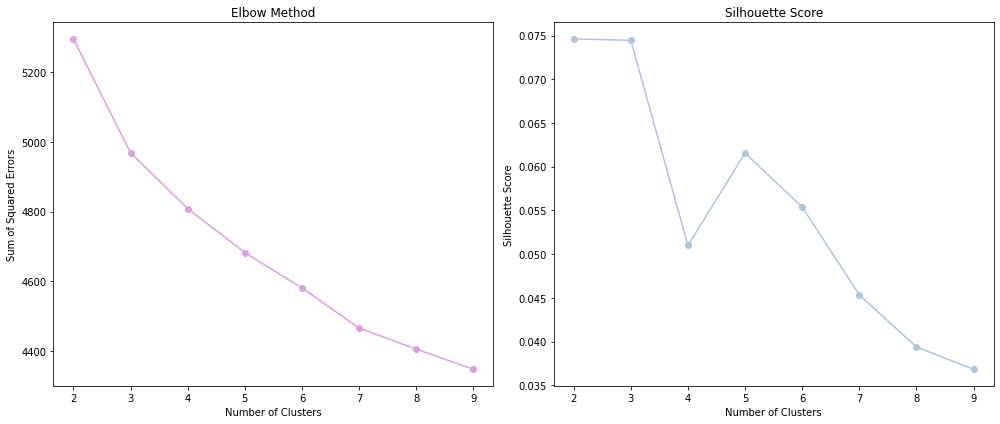

In [7]:
import matplotlib.pyplot as plt

clusters = list(sse.keys())
sse_values = list(sse.values())
silhouette_values = list(silhouette_scores.values())

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(clusters, sse_values, 'bo-', color='plum')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(clusters, silhouette_values, 'ro-', color='lightsteelblue')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')

plt.tight_layout()
plt.show()


In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

embeddings = embeddings_array

from sklearn.cluster import KMeans
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(embeddings)

tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

x = reduced_embeddings[:, 0]
y = reduced_embeddings[:, 1]

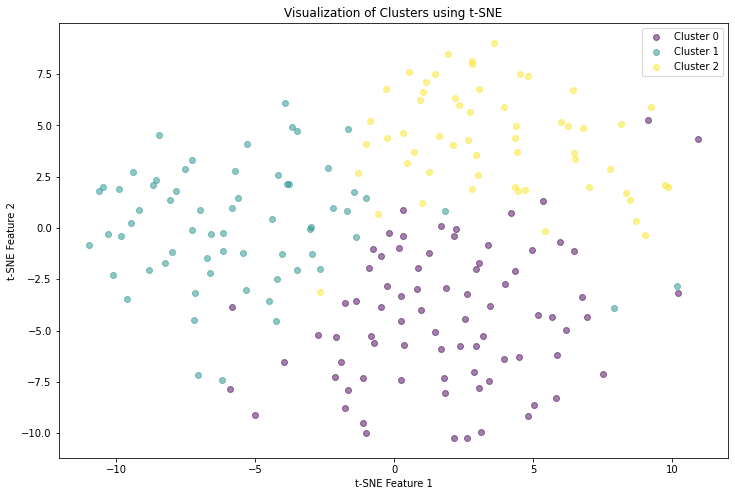

In [9]:
plt.figure(figsize=(12, 8))
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, k))

for i, color in zip(range(k), colors):
    plt.scatter(x[clusters == i], y[clusters == i], color=color, label=f'Cluster {i}', alpha=0.5)

plt.title('Visualization of Clusters using t-SNE')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()
plt.show()

# IsolationForest

ID текстов, считающихся аномалиями: [19214295 20146086 25139918 25410883 25853982 26469535 27218632 27793101
 28120581 28250304]
Процент текстов, считающихся аномалиями: 0.05


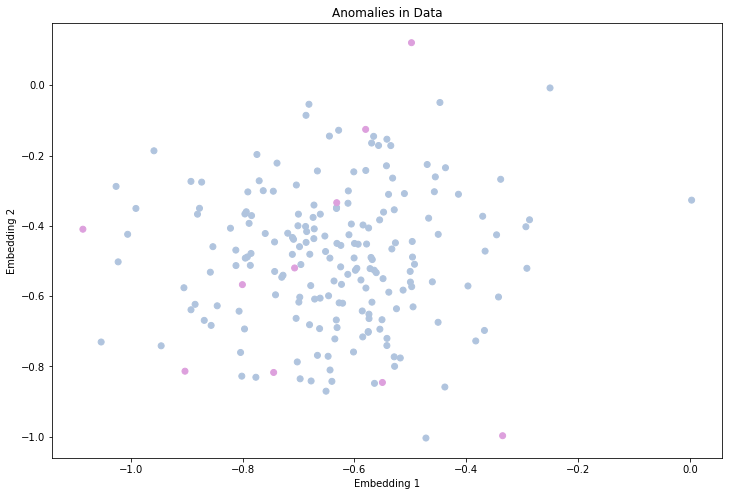

In [36]:
from sklearn.ensemble import IsolationForest
import numpy as np

embeddings = embeddings_array

clf = IsolationForest(random_state=42, contamination=0.05) 
outliers = clf.fit_predict(embeddings)

is_anomaly = clf.fit_predict(embeddings_array) == -1

anomaly_ids = text_ids_array[is_anomaly]
print("ID текстов, считающихся аномалиями:", anomaly_ids)
print("Процент текстов, считающихся аномалиями:", len(anomaly_ids)/len(text_ids_array))


import matplotlib.pyplot as plt
colors = ['lightsteelblue' if anomaly == 0 else 'plum' for anomaly in is_anomaly]

plt.figure(figsize=(12, 8))

plt.scatter(embeddings[:, 0], embeddings[:, 1], c=colors)
plt.title('Anomalies in Data')
plt.xlabel('Embedding 1')
plt.ylabel('Embedding 2')
plt.show()


# CVDD

In [17]:
from sklearn import svm
import numpy as np

embeddings = embeddings_array

model = svm.OneClassSVM(kernel='rbf', nu=0.1)
model.fit(embeddings)

OneClassSVM(nu=0.1)

In [33]:
preds = model.predict(embeddings)
normal_data = embeddings[preds == 1]
outliers = embeddings[preds == -1]  

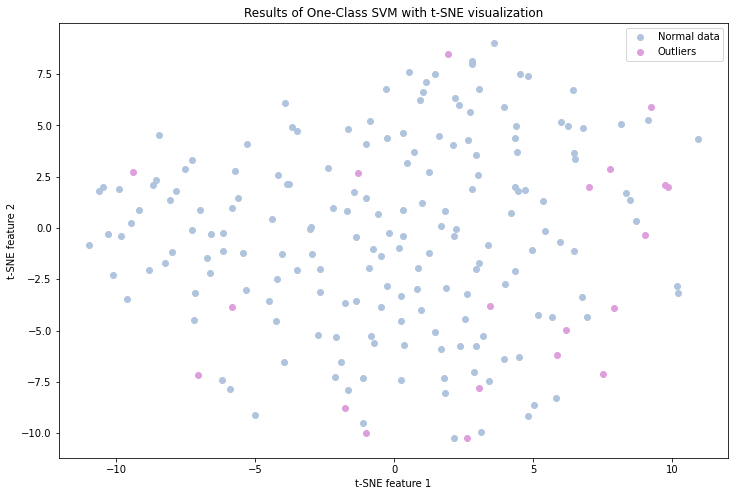

In [34]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

normal_data_tsne = embeddings_tsne[preds == 1]
outliers_tsne = embeddings_tsne[preds == -1]

plt.figure(figsize=(12, 8)) 
plt.scatter(normal_data_tsne[:, 0], normal_data_tsne[:, 1], c='lightsteelblue', label='Normal data')
plt.scatter(outliers_tsne[:, 0], outliers_tsne[:, 1], c='plum', label='Outliers')
plt.title('Results of One-Class SVM with t-SNE visualization')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend()
plt.show()

In [37]:
is_anomaly = preds == -1

anomaly_ids2 = text_ids_array[is_anomaly]

print("ID текстов, считающихся аномалиями:", anomaly_ids2)

ID текстов, считающихся аномалиями: [19214295 19610147 20146086 21308977 25139918 25210224 25410883 25853982
 26469535 27218632 27749582 27773410 27793101 28120581 28202869 28216610
 28250304 28272235 28353558 28595573]


In [32]:
anomaly_ids

array([19214295, 20146086, 25139918, 25410883, 25853982, 26469535,
       27218632, 27793101, 28120581, 28250304])

In [39]:
intersection = np.intersect1d(anomaly_ids, anomaly_ids2)

print("Пересечение массивов:", intersection)

Пересечение массивов: [19214295 20146086 25139918 25410883 25853982 26469535 27218632 27793101
 28120581 28250304]
